<a href="https://colab.research.google.com/github/kingsdigitallab/lwm-davizct/blob/main/notebooks/LwM_DAVIZCT_01_Explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zooniverse data exploration using [Zoonyper](https://github.com/kingsdigitallab/zoonyper)

## System set up

In [1]:
ipython = get_ipython()
IN_COLAB = "google.colab" in str(ipython)

In [2]:
%%capture
if IN_COLAB:
    !curl -sSL https://install.python-poetry.org | python - && \
        if [ ! -d "zoonyper" ] ; then git clone https://github.com/kingsdigitallab/zoonyper.git; fi && \
        cd zoonyper && \
        git pull && \
        ~/.local/bin/poetry build && \
        pip install dist/zoonyper-0.1.0.tar.gz

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import base64
import os
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
from IPython.display import Markdown as md
from IPython.display import display
from wordcloud import WordCloud

from zoonyper.project import Project

pd.options.plotting.backend = "plotly"

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 12

## Settings

In [4]:
data_path = "../data"

if IN_COLAB:
    from google.colab import drive

    # drive.flush_and_unmount()
    drive.mount("/content/drive")
    data_path = "drive/My Drive/Colab Data/lwm/davizct/data"

    !ls -l "drive/My Drive/Colab Data/lwm/davizct/data/downloads" | wc -l

In [5]:
def info(msg):
    return md(f">ℹ️ {msg}")


def mm(graph):
    graphbytes = graph.strip().encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url=f"https://mermaid.ink/img/{base64_string}"))

In [6]:
stat = os.stat(os.path.join(data_path, "0_raw", "workflows.csv"))
export_date = time.ctime(stat.st_mtime)

info(f"**This notebook is using data exported on {export_date}**")

>ℹ️ **This notebook is using data exported on Tue Mar 21 13:52:18 2023**

## Project data model

In [7]:
mm(
    """
erDiagram
    workflow ||--|{ annotation : has
    workflow }|--o{ subject_set: has
    subject_set }|--|{ subject: contains
    annotation ||--|| subject: on
    user ||..|{ annotation : makes
    user ||..|{ comment : writes
    tag }|--|{ comment : in
    comment ||--o{ subject : "written about"
"""
)

## Project

In [10]:
project = Project(os.path.join(data_path, "0_raw"))

### Disambiguate subjects
> **Warning: At the moment this step can't be run con Colab**

In [39]:
subjects_df = project.subjects

if not IN_COLAB and not project.are_subjects_disambiguated():
    subjects_df = project.disambiguate_subjects(os.path.join(data_path, "downloads"))

ℹ Information: Note that the subject IDs have been disambiguated
and the information can be found in the
`subject_id_disambiguated` column.
ℹ Information: Note that the subject IDs have been disambiguated
and the information can be found in the
`subject_id_disambiguated` column.


In [40]:
workflows = project.workflows
workflows.head(2)

,display_name,version,active,classifications_count,pairwise,grouped,prioritized,primary_language,first_task,tutorial_subject_id,retired_set_member_subjects_count,tasks,retirement,aggregation,strings,minor_version,start_date,end_date
workflow_id,,,,,,,,,,,,,,,,,,
12038,Classify and summarise articles (set 1),1,False,8,False,False,False,en,,,0,{},"{""options"":{""count"":5},""criteria"":""classificat...",{},{},1,2019-09-12,2021-06-21
12038,Classify and summarise articles (set 1),2,False,8,False,False,False,en,T0,,0,"{""T0"":{""help"":""T0.help"",""type"":""single"",""answe...","{""options"":{""count"":5},""criteria"":""classificat...",{},"{""T0.help"":"""",""T0.question"":""Enter a question.""}",2,2019-09-12,2021-06-21


ℹ Information: Note that the subject IDs have been disambiguated
and the information can be found in the
`subject_id_disambiguated` column.


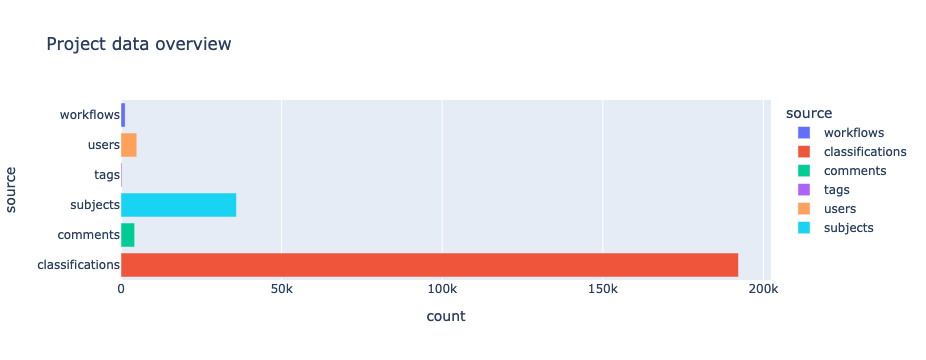

In [41]:
source = [
    "workflows",
    "classifications",
    "comments",
    "tags",
    "users",
]

count = [
    workflows.shape[0],
    project.classifications.shape[0],
    project.comments.shape[0],
    project.tags["name"].nunique(),
    project.classifications["user_name"].nunique(),
]

if project.are_subjects_disambiguated():
    source.append("subjects")
    count.append(subjects_df["subject_id_disambiguated"].nunique())

meta_df = pd.DataFrame(dict(source=source, count=count))

fig = px.bar(
    meta_df, x="count", y="source", color="source", title="Project data overview"
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

## Users

In [42]:
users = (
    project.classifications[["user_name", "user_group_ids"]]
    .value_counts("user_name")
    .reset_index(name="count")
)

info(f"There are **{users.shape[0]}** different users in the project.")

>ℹ️ There are **4938** different users in the project.

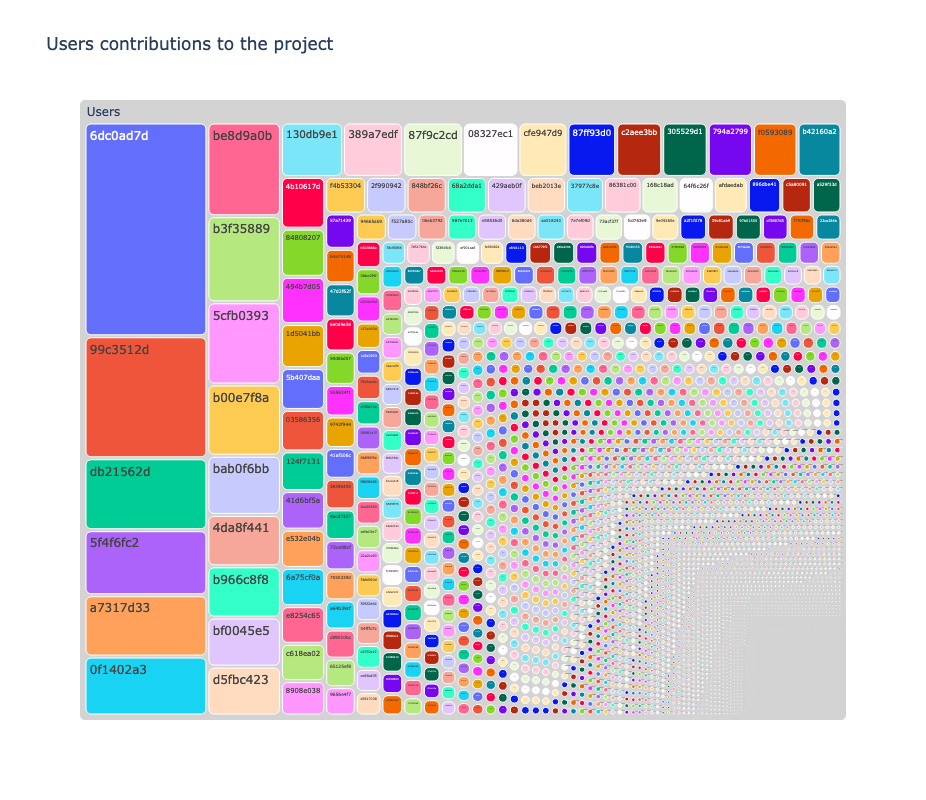

In [43]:
fig = px.treemap(
    users,
    path=[px.Constant("Users"), "user_name"],
    values="count",
    title=f"Users contributions to the project",
    height=800,
)
fig.update_traces(marker=dict(cornerradius=5), root_color="lightgrey")
fig.show()

## Comments

In [44]:
# there are names in the comments, is that a problem
comments = project.comments
comments["focus_type"] = comments["focus_type"].fillna("")
comments["len"] = comments["body"].str.len()
comments.head()

,body,focus_id,focus_type,user_id,user_login,created_at,len
comment_id,,,,,,,
1832647,To get things started I've collected comments ...,0,,1926730,miaridge,2019-09-16,443
1833213,"Image zoom! If you have a tall column of text,...",0,,1926730,miaridge,2019-09-16,162
1833591,Other requests / comments from Andre and Emma:...,0,,1926730,miaridge,2019-09-16,830
1834282,"Hi Mia, replying to your email here... If I re...",0,,1928640,andrepiza,2019-09-17,476
1837199,On the image zoom thing - it turns out that (s...,0,,1926730,miaridge,2019-09-19,561


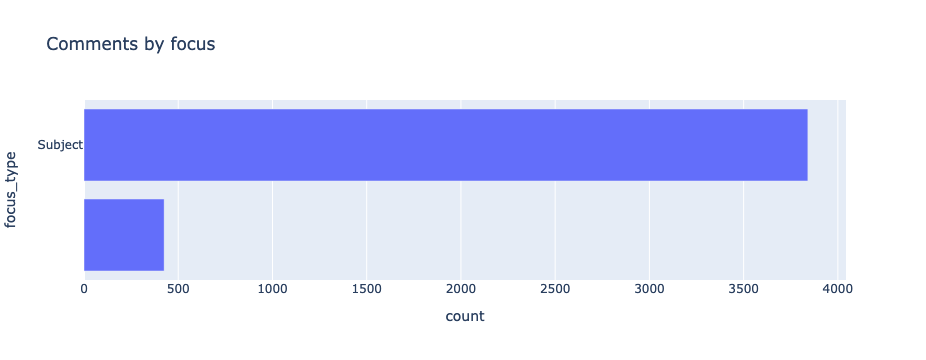

In [45]:
fig = px.bar(
    comments.value_counts("focus_type").reset_index(name="count"),
    y="focus_type",
    x="count",
    title="Comments by focus",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

## Tags

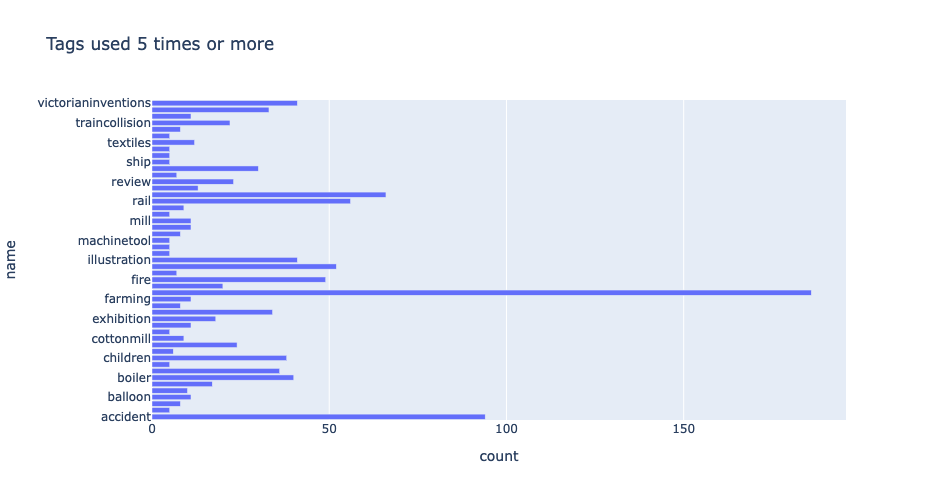

In [46]:
tags = project.tags.value_counts("name").reset_index(name="count")

fig = px.bar(
    tags[tags["count"] > 4],
    x="count",
    y="name",
    title="Tags used 5 times or more",
    height=500,
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

In [47]:
def show_wordcloud(words):
    wordcloud = WordCloud(background_color="white", width=4096, height=2304).fit_words(
        words
    )

    plt.axis("off")
    plt.imshow(wordcloud, interpolation="quadric")
    plt.show()

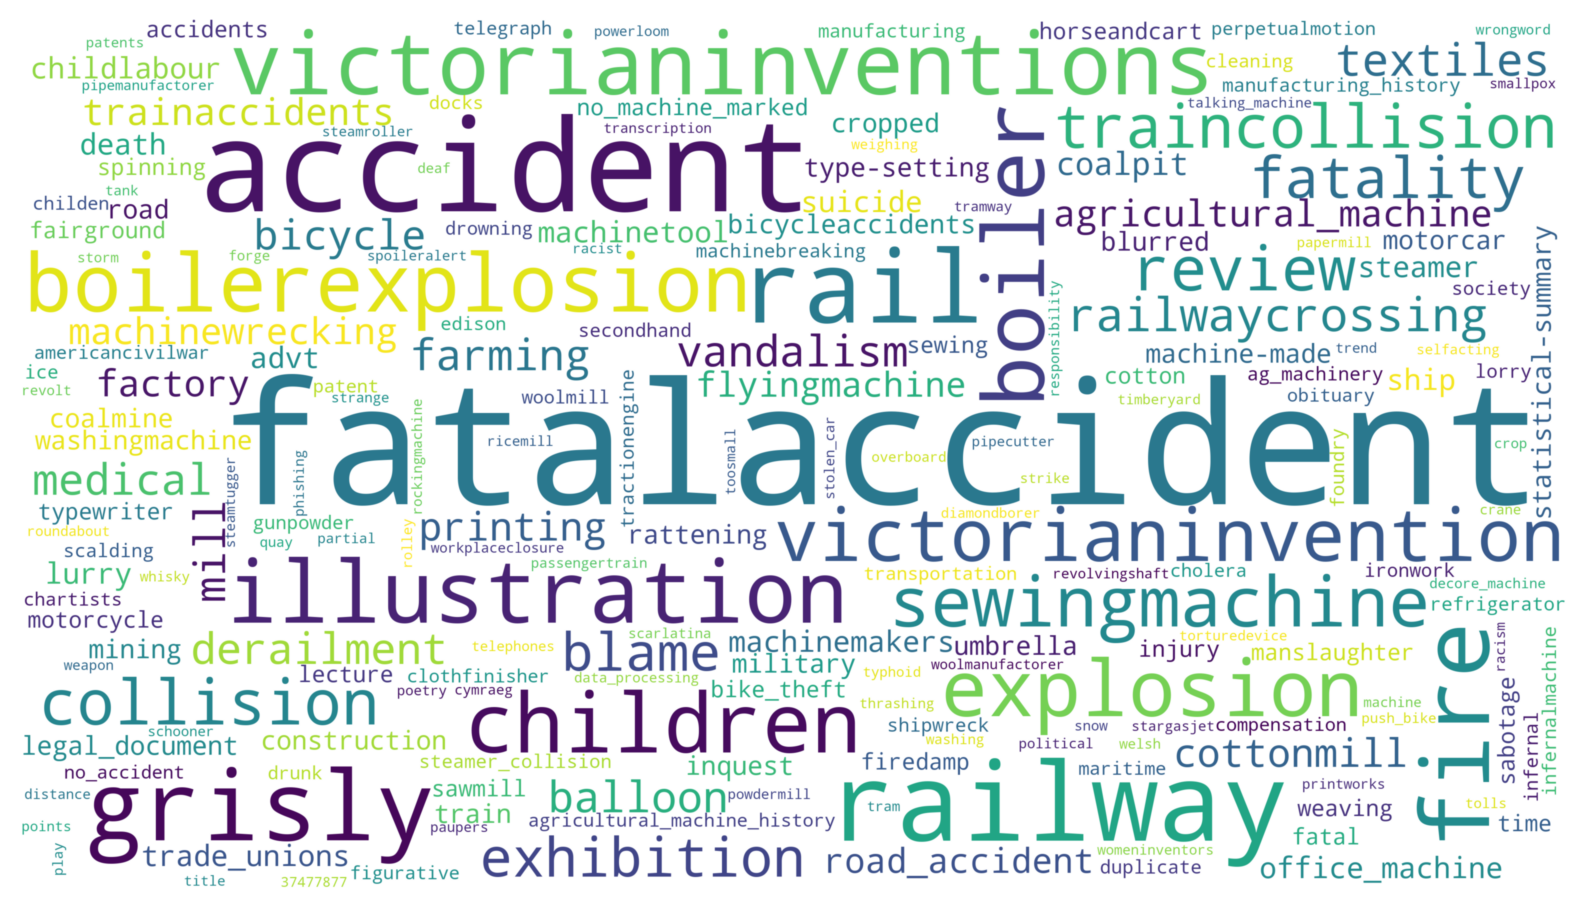

In [48]:
show_wordcloud(tags.set_index("name")["count"].to_dict())

## Workflows

In [49]:
workflows["start_date"] = workflows.apply(
    lambda x: project.classifications[project.classifications["workflow_id"] == x.name][
        "created_at"
    ].min(),
    axis=1,
)
workflows["end_date"] = workflows.apply(
    lambda x: project.classifications[project.classifications["workflow_id"] == x.name][
        "created_at"
    ].max(),
    axis=1,
)

workflows.head(2)

,display_name,version,active,classifications_count,pairwise,grouped,prioritized,primary_language,first_task,tutorial_subject_id,retired_set_member_subjects_count,tasks,retirement,aggregation,strings,minor_version,start_date,end_date
workflow_id,,,,,,,,,,,,,,,,,,
12038,Classify and summarise articles (set 1),1,False,8,False,False,False,en,,,0,{},"{""options"":{""count"":5},""criteria"":""classificat...",{},{},1,2019-09-12,2021-06-21
12038,Classify and summarise articles (set 1),2,False,8,False,False,False,en,T0,,0,"{""T0"":{""help"":""T0.help"",""type"":""single"",""answe...","{""options"":{""count"":5},""criteria"":""classificat...",{},"{""T0.help"":"""",""T0.question"":""Enter a question.""}",2,2019-09-12,2021-06-21


In [50]:
workflows_timeline_df = (
    workflows.reset_index()
    .groupby(["workflow_id", "display_name", "start_date", "end_date", "active"])
    .count()
    .reset_index()
    .sort_values(by="display_name", key=lambda x: x.str.lower())
)

info(
    f"There are **{workflows_timeline_df.shape[0]}** different workflows in the project, "
    f"of which **{workflows_timeline_df[workflows_timeline_df['active'] == True].shape[0]}** are active."
)

>ℹ️ There are **21** different workflows in the project, of which **5** are active.

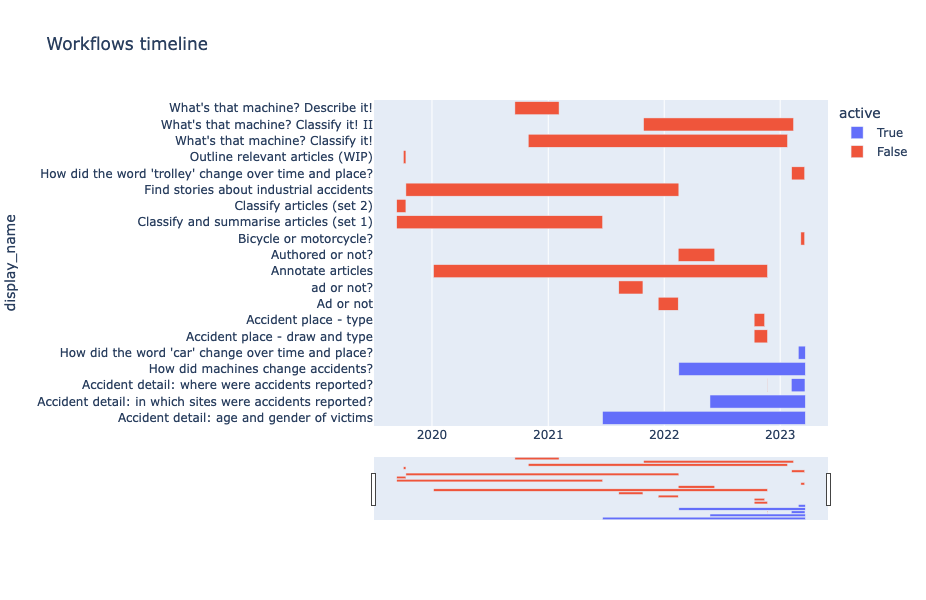

In [51]:
px.timeline(
    workflows_timeline_df,
    x_start="start_date",
    x_end="end_date",
    y="display_name",
    color="active",
    title="Workflows timeline",
    height=600,
).update_xaxes(rangeslider_visible=True)

## Focus on a workflow
Select a workflow from the dropdown. After selecting a new workflow, run the cells below.

In [52]:
workflow_options = list(
    set(workflows["display_name"].sort_values(ascending=True).items())
)
workflow_options = [(name, id) for id, name in workflow_options]

workflow_widget = widgets.Dropdown(
    options=workflow_options,
    value=20921,
    description="Select a workflow:",
    layout=widgets.Layout(width="auto"),
    style=dict(description_width="auto"),
)
display(workflow_widget)

Dropdown(description='Select a workflow:', index=7, layout=Layout(width='auto'), options=(("What's that machin…

In [53]:
workflow_id = workflow_widget.value
workflow = workflows.loc[workflow_id]
workflow_name = workflow["display_name"].iloc[0]

md(f"### *{workflow_name}* workflow")

### *How did machines change accidents?* workflow

### Classifications

In [54]:
classifications = project.classifications[
    project.classifications["workflow_id"] == workflow_id
]
classifications.head(2)

,user_name,user_ip,workflow_id,workflow_version,created_at,gold_standard,expert,subject_ids,user_logged_in,source,...,subject_selection_state.user_has_finished_workflow,seen_before,seconds,T1,T0,T3,T2,T4,T6,T5
classification_id,,,,,,,,,,,,,,,,,,,,,
397282864,130db9e1,2eb8c8,20921,1.1,2022-02-16,False,False,72990895,True,api,...,False,,56,,There is only one article on the image and it ...,,"A transport (road, rail, water, etc) accident",,,
397283385,130db9e1,bfcc1a,20921,1.1,2022-02-16,False,False,72990886,True,api,...,False,,168,,There are no relevant articles on this image,,,,,


In [55]:
classifications_by_day = classifications.value_counts("created_at").reset_index(
    name="count"
)
classifications_by_day = classifications_by_day.sort_values("created_at")
classifications_by_day["cumulative_count"] = classifications_by_day["count"].cumsum()
classifications_by_day = classifications_by_day.sort_values("created_at")

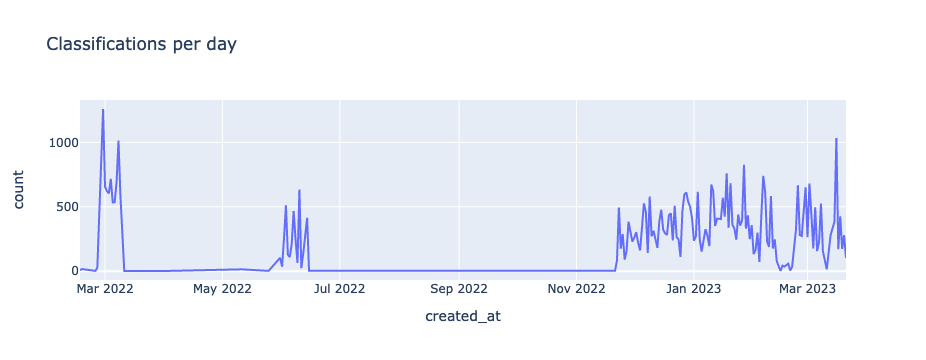

In [56]:
fig = classifications_by_day.plot.line(
    x="created_at", y="count", title="Classifications per day"
)
fig.show()

In [57]:
info(
    f"The workflow *{workflow_name}* has been worked on during **{classifications_by_day.shape[0]}** days."
)

>ℹ️ The workflow *How did machines change accidents?* has been worked on during **157** days.

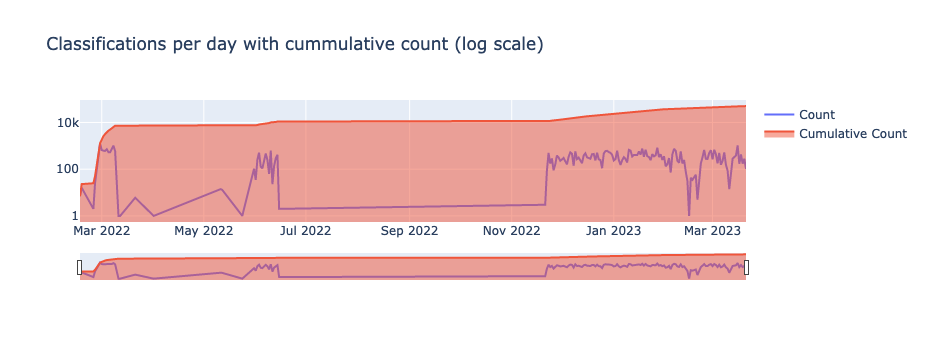

In [58]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=classifications_by_day["created_at"],
        y=classifications_by_day["count"],
        mode="lines",
        name="Count",
    )
)

fig.add_trace(
    go.Scatter(
        x=classifications_by_day["created_at"],
        y=classifications_by_day["cumulative_count"],
        mode="lines",
        name="Cumulative Count",
        fill="tozeroy",
    )
)

fig.update_xaxes(rangeslider_visible=True).update_yaxes(type="log")

fig.update_layout(
    barmode="group", title="Classifications per day with cummulative count (log scale)"
)

fig.show()

#### Classification by user

In [59]:
classifications_by_user = classifications.value_counts("user_name").reset_index(
    name="count"
)

In [60]:
info(
    f"The workflow *{workflow_name}* has **{classifications_by_user.shape[0]}** different users."
)

>ℹ️ The workflow *How did machines change accidents?* has **1589** different users.

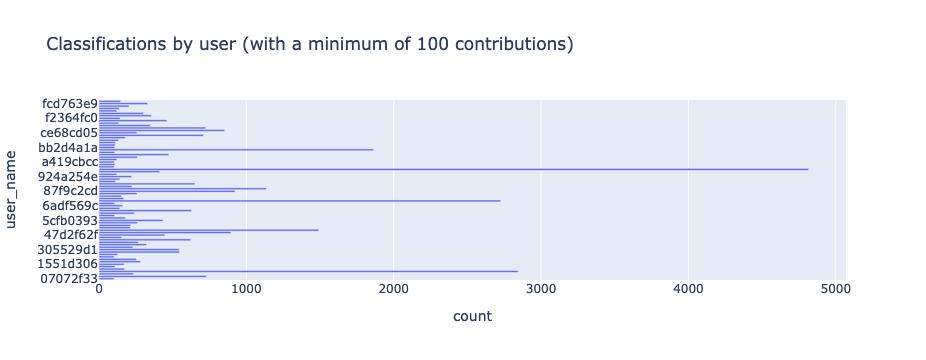

In [61]:
fig = classifications_by_user[classifications_by_user["count"] > 100].plot.bar(
    x="count",
    y="user_name",
    title="Classifications by user (with a minimum of 100 contributions)",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()

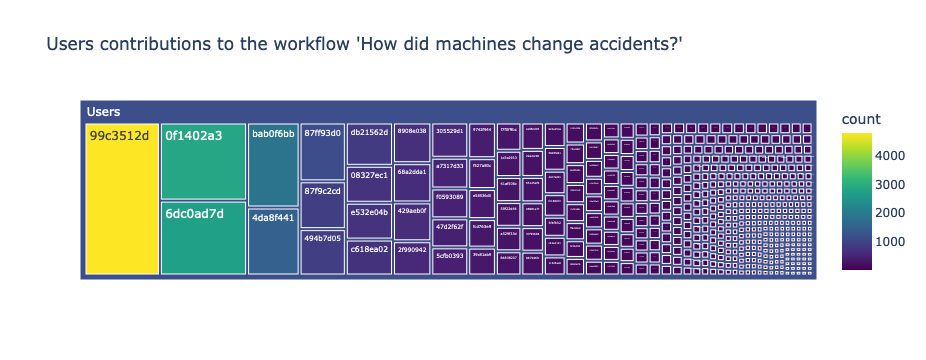

In [62]:
fig = px.treemap(
    classifications_by_user[classifications_by_user["count"] > 10],
    path=[px.Constant("Users"), "user_name"],
    values="count",
    color="count",
    color_continuous_scale="Viridis",
    title=f"Users contributions to the workflow '{workflow_name}'",
)
fig.show()

### Subjects

In [63]:
subjects = subjects_df[subjects_df["workflow_id"] == workflow_id]
subjects.head(2)

,subject_id_disambiguated,project_id,workflow_id,subject_set_id,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,...,!original_metadata.newspaper title,!original_metadata.!zooniverse_file_md5,!original_metadata.!zooniverse_file_stem,,!issue,!article_id,!textblock_id,newspaper_date,newspaper_place,newspaper_title
subject_id,,,,,,,,,,,,,,,,,,,,,
73320307,30702,9943,20921,102701,{'0': 'https://panoptes-uploads.zooniverse.org...,4,2022-06-02,consensus,2022-02-24,2022-11-09,...,,,,,,,,,,
73320308,22232,9943,20921,102701,{'0': 'https://panoptes-uploads.zooniverse.org...,5,2022-06-10,classification_count,2022-02-24,2022-11-09,...,,,,,,,,,,


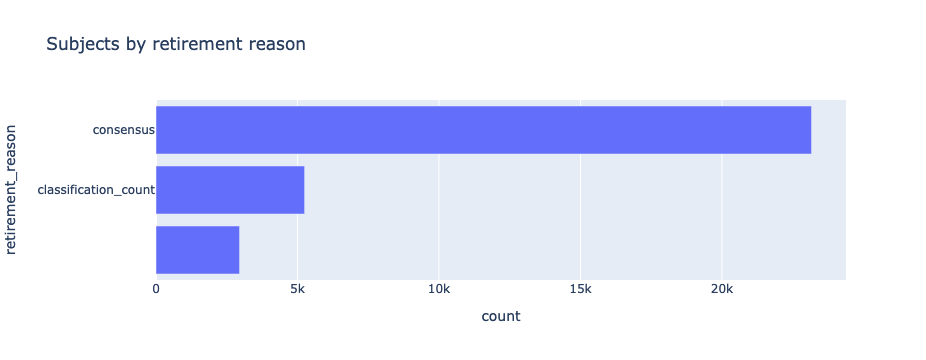

In [64]:
fig = px.bar(
    subjects.value_counts("retirement_reason").reset_index(name="count"),
    x="count",
    y="retirement_reason",
    title="Subjects by retirement reason",
)
fig.update_layout(yaxis=dict(categoryorder="category ascending"))
fig.show()